In [31]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from datetime import datetime
import matplotlib.animation as animation
from copy import deepcopy as copy
from src import convert

### Initialization

In [32]:
start_time = datetime.now()

# Data extracted from the horizon results
DT = 600 # in seconds
T = 2500

### Body class

In [33]:
class Body():

    all = []

    def __init__(self, name, pos, vel, acc, gm):
        self.name = name
        self.pos = pos
        self.vel = vel
        self.acc = acc
        self.gm = gm
        self.pos_evol = np.zeros((T,3))
        self.pos_evol[0] = self.pos
        self.vel_evol = np.zeros((T,3))
        self.vel_evol[0] = self.vel
        self.acc_evol = np.zeros((T,3))
        self.acc_evol[0] = self.acc
        Body.all.append(self)

    def compute_acceleration(self, other_body=None):
        if other_body is None:
            other_body=Body.all
        elif isinstance(other_body, Body):
            other_body = [other_body]

        acc = np.array([0,0,0])
        for other_body in Body.all:
            if self.name != other_body.name:
                r = other_body.pos - self.pos
                d = np.sqrt(np.sum(r**2))
                acc = acc + r * other_body.gm / (d**3)
        return acc

### Body definition

In [34]:
mimas = Body(
    name = 'Mimas',
    pos  = np.array([-1.813557294137345E+05, 3.492995866271013E+04, 5.054192147215439E+03]),
    vel  = np.array([-2.445920348718876E+00, 1.416736794928916E+01, 1.873213454946043E-02]),
    acc  = np.array([0,0,0]),
    gm   = 2.503489)

thetys = Body(
    name = 'Thetys',
    pos  = np.array([-1.889929479196472E+05, -2.260662471700913E+05, -7.020174976279632E+02]),
    vel  = np.array([8.706811449016753E+00, -7.280896606319645E+00, -2.143307520131600E-01]),
    acc  = np.array([0,0,0]),
    gm   = 41.21)

titan = Body(
    name = 'Titan',
    pos  = np.array([2.956179324256932E+05, 1.212611254175863E+06, -6.683800852915738E+02]),
    vel  = np.array([-5.322398770209340E+00, 1.190373084298060E+00, -3.847254100240810E-02]),
    acc  = np.array([0,0,0]),
    gm   = 8978.14)

saturn = Body(
    name = 'Saturn',
    pos  = np.array([0,0,0]),
    vel  = np.array([0,0,0]),
    acc  = np.array([0,0,0]),
    gm   = 37931206.2)

# Initial acceleration
# for body in [mimas, thetys, titan]:
#     body.acc = body.compute_acceleration(saturn)

### Leap Frog integrator

In [35]:
# for t in range(0,T):
    
#     for body in [mimas, thetys]:

#         body.pos = body.pos + body.vel * DT + body.acc/2 * DT**2
#         body.vel =            body.vel      + body.acc/2 * DT
#         body.acc = body.compute_acceleration(saturn)
#         if body is titan:
#             body.acc *= 5.5
#         body.vel =            body.vel      + body.acc/2 * DT

#         body.pos_evol[t] = body.pos
#         body.vel_evol[t] = body.vel

### Runge-Kutta integrator

In [36]:
# Acceleration function : f(t,y) -> (v,a)     with y = (p,v)
def f(t, y, body = None) -> np.array:
    pos = y[:3]
    vel = y[3:]

    gm = body.gm if body is not None else 0

    r = pos
    d = np.sqrt(np.sum(r**2))
    acc = - r * (saturn.gm + gm) / (d**3)

    return np.concatenate((vel, acc))

# Runge kutta 4th order : rk4(t,dt,y,evaluate) -> y     with y = (p,v)
def rk4(t,dt,y,evaluate, body = None) -> np.array:

    if body is thetys and t==dt:
        print(y)

    k1 = evaluate(t, y, body = body)
    if body is thetys and t==dt:
        print("k1", k1)
    k2 = evaluate(t + 0.5*dt, y + 0.5*k1*dt, body = body)
    if body is thetys and t==dt:
        print("k2", k2)
    k3 = evaluate(t + 0.5*dt, y + 0.5*k2*dt, body = body)
    if body is thetys and t==dt:
        print("k3", k3)
    k4 = evaluate(t + dt, y + dt*k3, body = body)
    if body is thetys and t==dt:
        print("k4", k4)
    
    y_new = y + (1./6.)*(k1+ 2.*k2 + 2.*k3 + k4) * dt

    if body is thetys and t==dt:
        print(y_new)

    return y_new

# Time evolution
for t in range(1,T):    
    for body in [mimas, thetys, titan]:

        y = np.concatenate((body.pos, body.vel))
        y = rk4(t*DT, DT, y, f, body = body)

        body.pos = y[:3]
        body.vel = y[3:]

        body.pos_evol[t] = body.pos
        body.vel_evol[t] = body.vel

[-1.88992948e+05 -2.26066247e+05 -7.02017498e+02  8.70681145e+00
 -7.28089661e+00 -2.14330752e-01]
k1 [ 8.70681145e+00 -7.28089661e+00 -2.14330752e-01  2.80205866e-04
  3.35171704e-04  1.04082942e-06]
k2 [ 8.79087321e+00 -7.18034509e+00 -2.14018503e-01  2.76276135e-04
  3.38340296e-04  1.13592658e-06]
k3 [ 8.78969429e+00 -7.17939452e+00 -2.13989974e-01  2.76349349e-04
  3.38431022e-04  1.13624245e-06]
k4 [ 8.87262106e+00 -7.07783799e+00 -2.13649007e-01  2.72383192e-04
  3.41553835e-04  1.23117352e-06]
[-1.83718891e+05 -2.30374069e+05 -8.30417169e+02  8.87259545e+00
 -7.07786979e+00 -2.13649118e-01]


### Plot position evolution

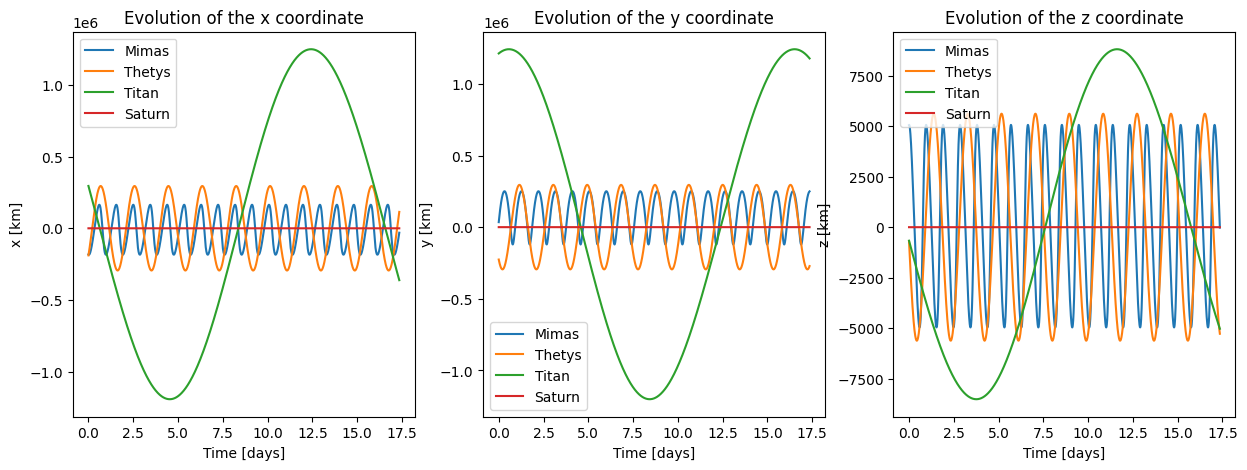

In [37]:
fig = plt.figure(figsize=(15,5))

# Evolution of the x coordinate
plt.subplot(131)
plt.title('Evolution of the x coordinate')
for body in Body.all:
    plt.plot(np.arange(T)*DT/86400.0, body.pos_evol[:,0], label=body.name)
plt.xlabel('Time [days]')
plt.ylabel('x [km]')
plt.legend()

# Evolution of the y coordinate
plt.subplot(132)
plt.title('Evolution of the y coordinate')
for body in Body.all:
    plt.plot(np.arange(T)*DT/86400.0, body.pos_evol[:,1], label=body.name)
plt.xlabel('Time [days]')
plt.ylabel('y [km]')
plt.legend()

# Evolution of the z coordinate
plt.subplot(133)
plt.title('Evolution of the z coordinate')
for body in Body.all:
    plt.plot(np.arange(T)*DT/86400.0, body.pos_evol[:,2], label=body.name)
plt.xlabel('Time [days]')
plt.ylabel('z [km]')
plt.legend()

### 3D representation of orbits

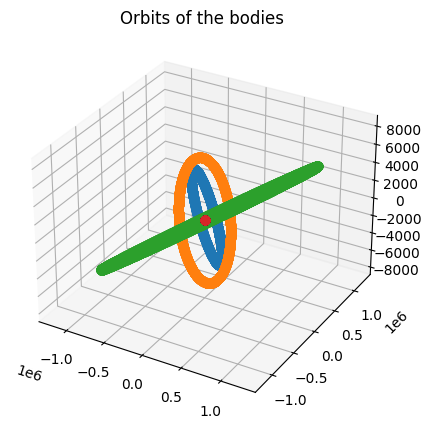

In [38]:
fig = plt.figure(figsize=(5,5))

ax = plt.subplot(111, projection='3d')
ax.set_title('Orbits of the bodies')
for body in Body.all:
    ax.plot(body.pos_evol[:,0], body.pos_evol[:,1], body.pos_evol[:,2], marker='o', label=body.name)

### Plot velocity evolution

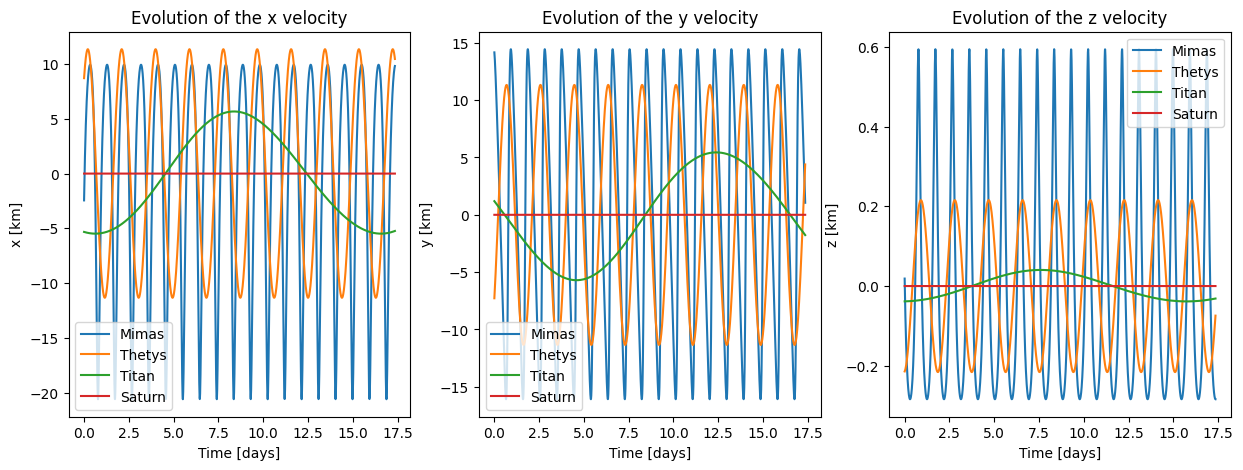

In [39]:
fig = plt.figure(figsize=(15,5))

# Evolution of the x velocity
plt.subplot(131)
plt.title('Evolution of the x velocity')
for body in Body.all:
    plt.plot(np.arange(T)*DT/86400.0, body.vel_evol[:,0], label=body.name)
plt.xlabel('Time [days]')
plt.ylabel('x [km]')
plt.legend()

# Evolution of the y velocity
plt.subplot(132)
plt.title('Evolution of the y velocity')
for body in Body.all:
    plt.plot(np.arange(T)*DT/86400.0, body.vel_evol[:,1], label=body.name)
plt.xlabel('Time [days]')
plt.ylabel('y [km]')
plt.legend()

# Evolution of the z velocity
plt.subplot(133)
plt.title('Evolution of the z velocity')
for body in Body.all:
    plt.plot(np.arange(T)*DT/86400.0, body.vel_evol[:,2], label=body.name)
plt.xlabel('Time [days]')
plt.ylabel('z [km]')
plt.legend()

### Convert to orbital elements

In [40]:
for body in Body.all:
    body.orb_evol = np.zeros((T,6))
    for t in range(0,T):
        body.orb_evol[t] = convert.cartesian_to_orbital(body.pos_evol[t], body.vel_evol[t], saturn.gm + body.gm)
        if body is thetys and t < 10:
            print(f"At t={t}: {[round(i,3) for i in body.orb_evol[t]]}")

At t=0: [294975.024, 1.409, 0.125, 0.007, 0.006, nan]
At t=1: [294975.024, 1.406, 0.158, 0.007, 0.006, nan]
At t=2: [294975.024, 1.402, 0.19, 0.007, 0.006, nan]
At t=3: [294975.024, 1.397, 0.222, 0.007, 0.006, nan]
At t=4: [294975.024, 1.392, 0.255, 0.007, 0.006, nan]
At t=5: [294975.024, 1.385, 0.287, 0.007, 0.006, nan]
At t=6: [294975.024, 1.378, 0.319, 0.007, 0.006, nan]
At t=7: [294975.024, 1.371, 0.35, 0.007, 0.006, nan]
At t=8: [294975.024, 1.362, 0.382, 0.007, 0.006, nan]
At t=9: [294975.024, 1.353, 0.413, 0.007, 0.006, nan]
